In [1]:
import os
os.chdir(os.getcwd() + '/../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import rescale
from sklearn.decomposition import PCA
from sklearn.utils.graph_shortest_path import graph_shortest_path

from scipy.io import loadmat


from scripts.isomap import *
from scripts.pca import *

# 1. Face recognition

### 1.a. Eigenfaces

In this section first 6 eigenfaces for each subject are explored.

In [3]:
dirpath = 'data/yalefaces/'
directory = os.fsencode(dirpath)

subject_1_data = []
subject_2_data = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if 'test' in filename:
        continue
    if filename.startswith('subject01'): 
        img = plt.imread(dirpath + filename)
        img = rescale(img, 0.25, anti_aliasing=False)
        img = img.flatten()
        subject_1_data.append(img)
    elif filename.startswith('subject02'):
        img = plt.imread(dirpath + filename)
        img = rescale(img, 0.25, anti_aliasing=False)
        img = img.flatten()
        subject_2_data.append(img)
    else:
        continue
        
X1 = np.array(subject_1_data)
X2 = np.array(subject_2_data)

### Subject 01

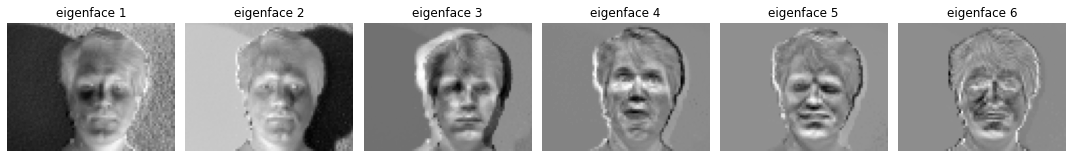

In [4]:
pca_1 = PCA(n_components=6).fit(X1)
eigenfaces_1 = pca_1.components_

# visualization of eigenvectors (eigenfaces)
height = 61
width = 80
fig, ax = plt.subplots(1, 6, figsize = (15, 50))

# compressed images
for i, img in enumerate(eigenfaces_1):
    ax[i].imshow(img.reshape((height, width)), cmap='gray')
    ax[i].set_title(f"eigenface {i+1}")
    
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

### Subject 02

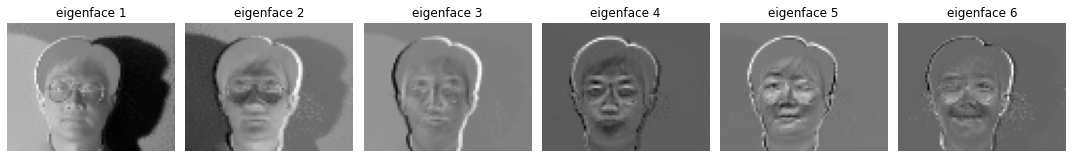

In [5]:
pca_2 = PCA(n_components=6).fit(X2)
eigenfaces_2 = pca_2.components_

# visualization of eigenvectors (eigenfaces)
height = 61
width = 80
fig, ax = plt.subplots(1, 6, figsize = (15, 50))

# compressed images
for i, img in enumerate(eigenfaces_2):
    ax[i].imshow(img.reshape((height, width)), cmap='gray')
    ax[i].set_title(f"eigenface {i+1}")
    
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

The eigenfaces seem to be a combination of different faces which is inline with the intuition that each projection axis is a linear combination of original axes. The expression seems to become more specific the higher the order of eigenface is. Shadows are also more pronounce in the first few eigenfaces further reinforcing the fact that the first eigenfaces are supposed to capture the highest variation in the data. The glasses are more pronounce in the subject 2 eigenfaces due to the proportion of the images wearing them.

### 1.b. Face recognition via projection errors to 1st eigenfaces

In [6]:
# TEST DATA PREPARATION
test_data = []

# subject 01 test
img = plt.imread('data/yalefaces/subject01-test.gif')
img = rescale(img, 0.25, anti_aliasing=False)
img = img.flatten()
test_data.append(img.reshape((-1, 1)))

# subject 02 test
img = plt.imread('data/yalefaces/subject02-test.gif')
img = rescale(img, 0.25, anti_aliasing=False)
img = img.flatten()
test_data.append(img.reshape((-1, 1)))

# PCA PREPARATION
n_comp = 1
pcas = [PCA(n_components=1).fit(X1), PCA(n_components=1).fit(X2)]

# MEAN VECTORS FOR BOTH SUBJECTS
means = []
means.append(X1.mean(axis=0).reshape((-1, 1)))
means.append(X2.mean(axis=0).reshape((-1, 1)))

In [7]:
# computing l2 distances between test images and the 1st eigenface of 2 subjects

s = np.empty((2, 2))
# fig, ax = plt.subplots(2, 2)
for i in range(s.shape[0]):
    for j in range(s.shape[1]):
        test_v = test_data[j]
        proj_v = pcas[i].transform(test_v.reshape(1, -1)).reshape((-1, 1)) + means[i]
        
#         # plot projections
#         ax[i, j].imshow(proj_v.reshape((height, width)), cmap='gray')
#         ax[i, j].set_title(f"projection, subject {j+1} \nto eigenface {i+1}")
        
        d = test_v - proj_v
        s[i, j] = np.matmul(d.T, d)
        
# for ax in fig.axes:
#     ax.axis('off')
# plt.tight_layout()

In [8]:
s

array([[   9550.58493924,  232010.17496878],
       [1129645.44860434,   69047.2327826 ]])

s_ij indicates projection residual of subject j with eigenface i. Face recognition is done based on the minimum projection residual to a a particular eigenface (the closest eigenface). In this case, both test subjects are recognized correctly (subject 1 is closer to eigenface 1 and subject 2 is closer to eigenface 2).

# 2. ISOMAP

In [9]:
data = loadmat('data/isomap.mat')
data = data['images'].T

In [10]:
data.shape

(698, 4096)

### 2.a. Adjacency matrix

In the following procedure, adjacency matrix is defined as a matrix A with each entry A_ij corresponding to a_ij = euclidean distance between datapoint i and datapoint j if a_ij <= epsilon and 0 otherwise (defined as unconnected). Here, epsilon value of 12 is used.

In [11]:
A = construct_distance_matrix(data, data)

average num neighbors: 40.335243553008596


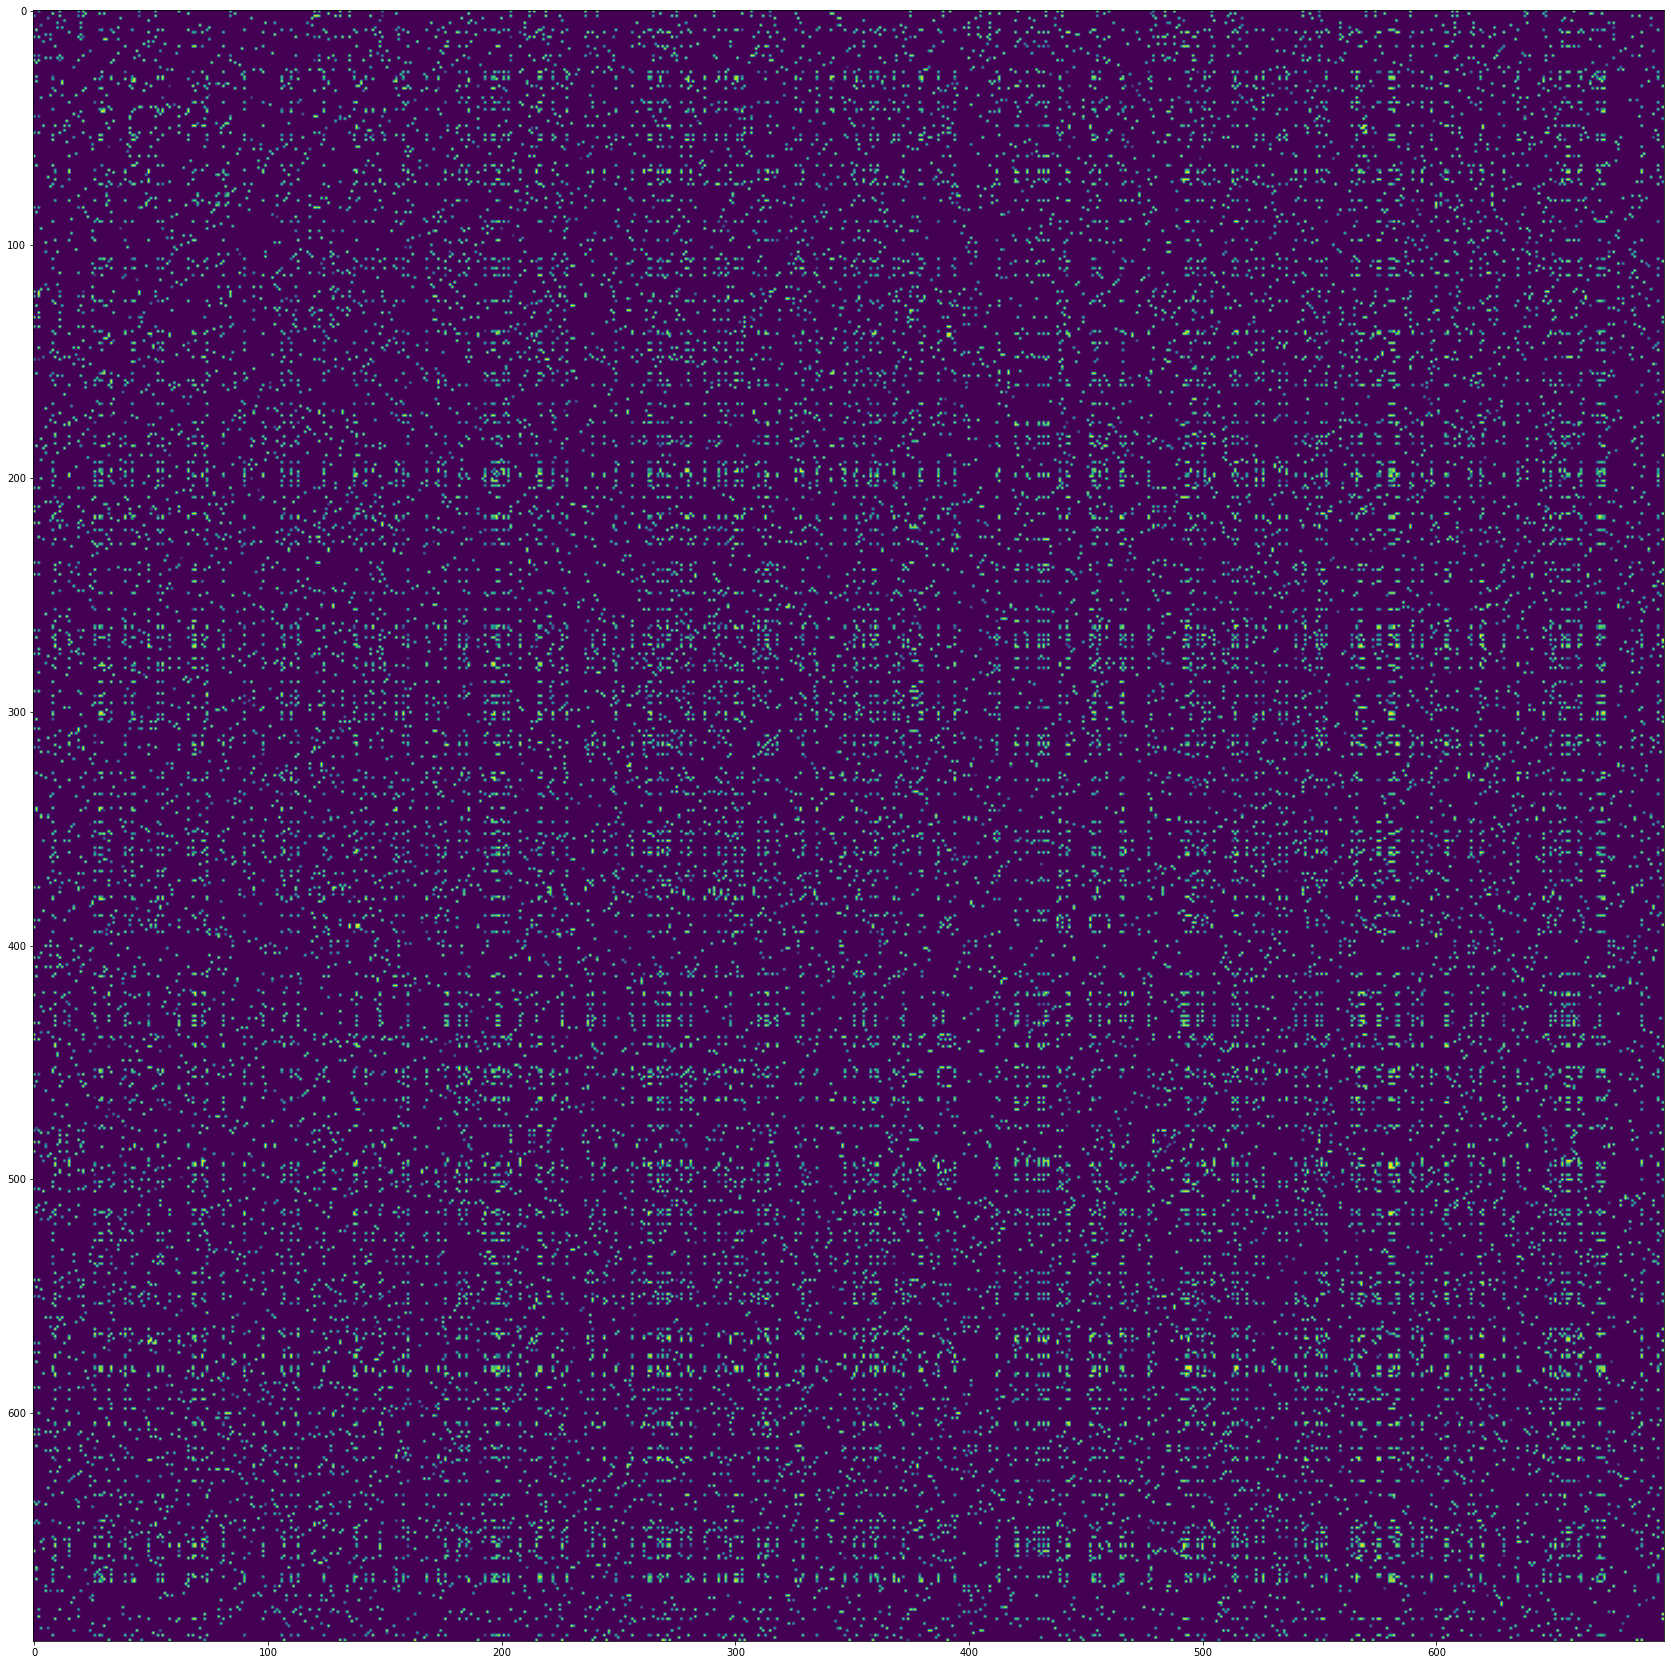

In [12]:
A[A > 12] = 0
print(f"average num neighbors: {(A > 0).sum(axis=1).mean()}")

plt.figure(figsize=(30, 30))
plt.imshow(A)

### 2.b. Visualization of ISOMAP result 

In the following procedure, run_isomap of Isomap class uses the same method as shown above to construct adjacency matrix and does the following in order:
* computation of dissimilarity matrix D, m x m matrix (with m = # of datapoints) with each element D_ij defined as the shortest distance between datapoint i and datapoint j along connected points (0 if unconnected) 
* computation of G = -1/2 HD^2H, with H = centering matrix (m x m matrix defined as I - 1/m x **1** where **1** is  m x m matrix of ones)
* eigendecomposition of G
* computation of Z, defined as m (# of datapoints) x d (# dimension of projection) matrix, by multiplying U (m x d matrix of d eigenvectors) and diagonal matrix of d-largest eigenvalues

Z is then plotted as the d-dimensional embedding (2 in this case), preserving the dissimilarities between datapoints. Image snippets are included at random to analyze whether their similarities are captured in the embedding.

In [13]:
isomap = Isomap(data)
Z = isomap.run_isomap(2, 12)

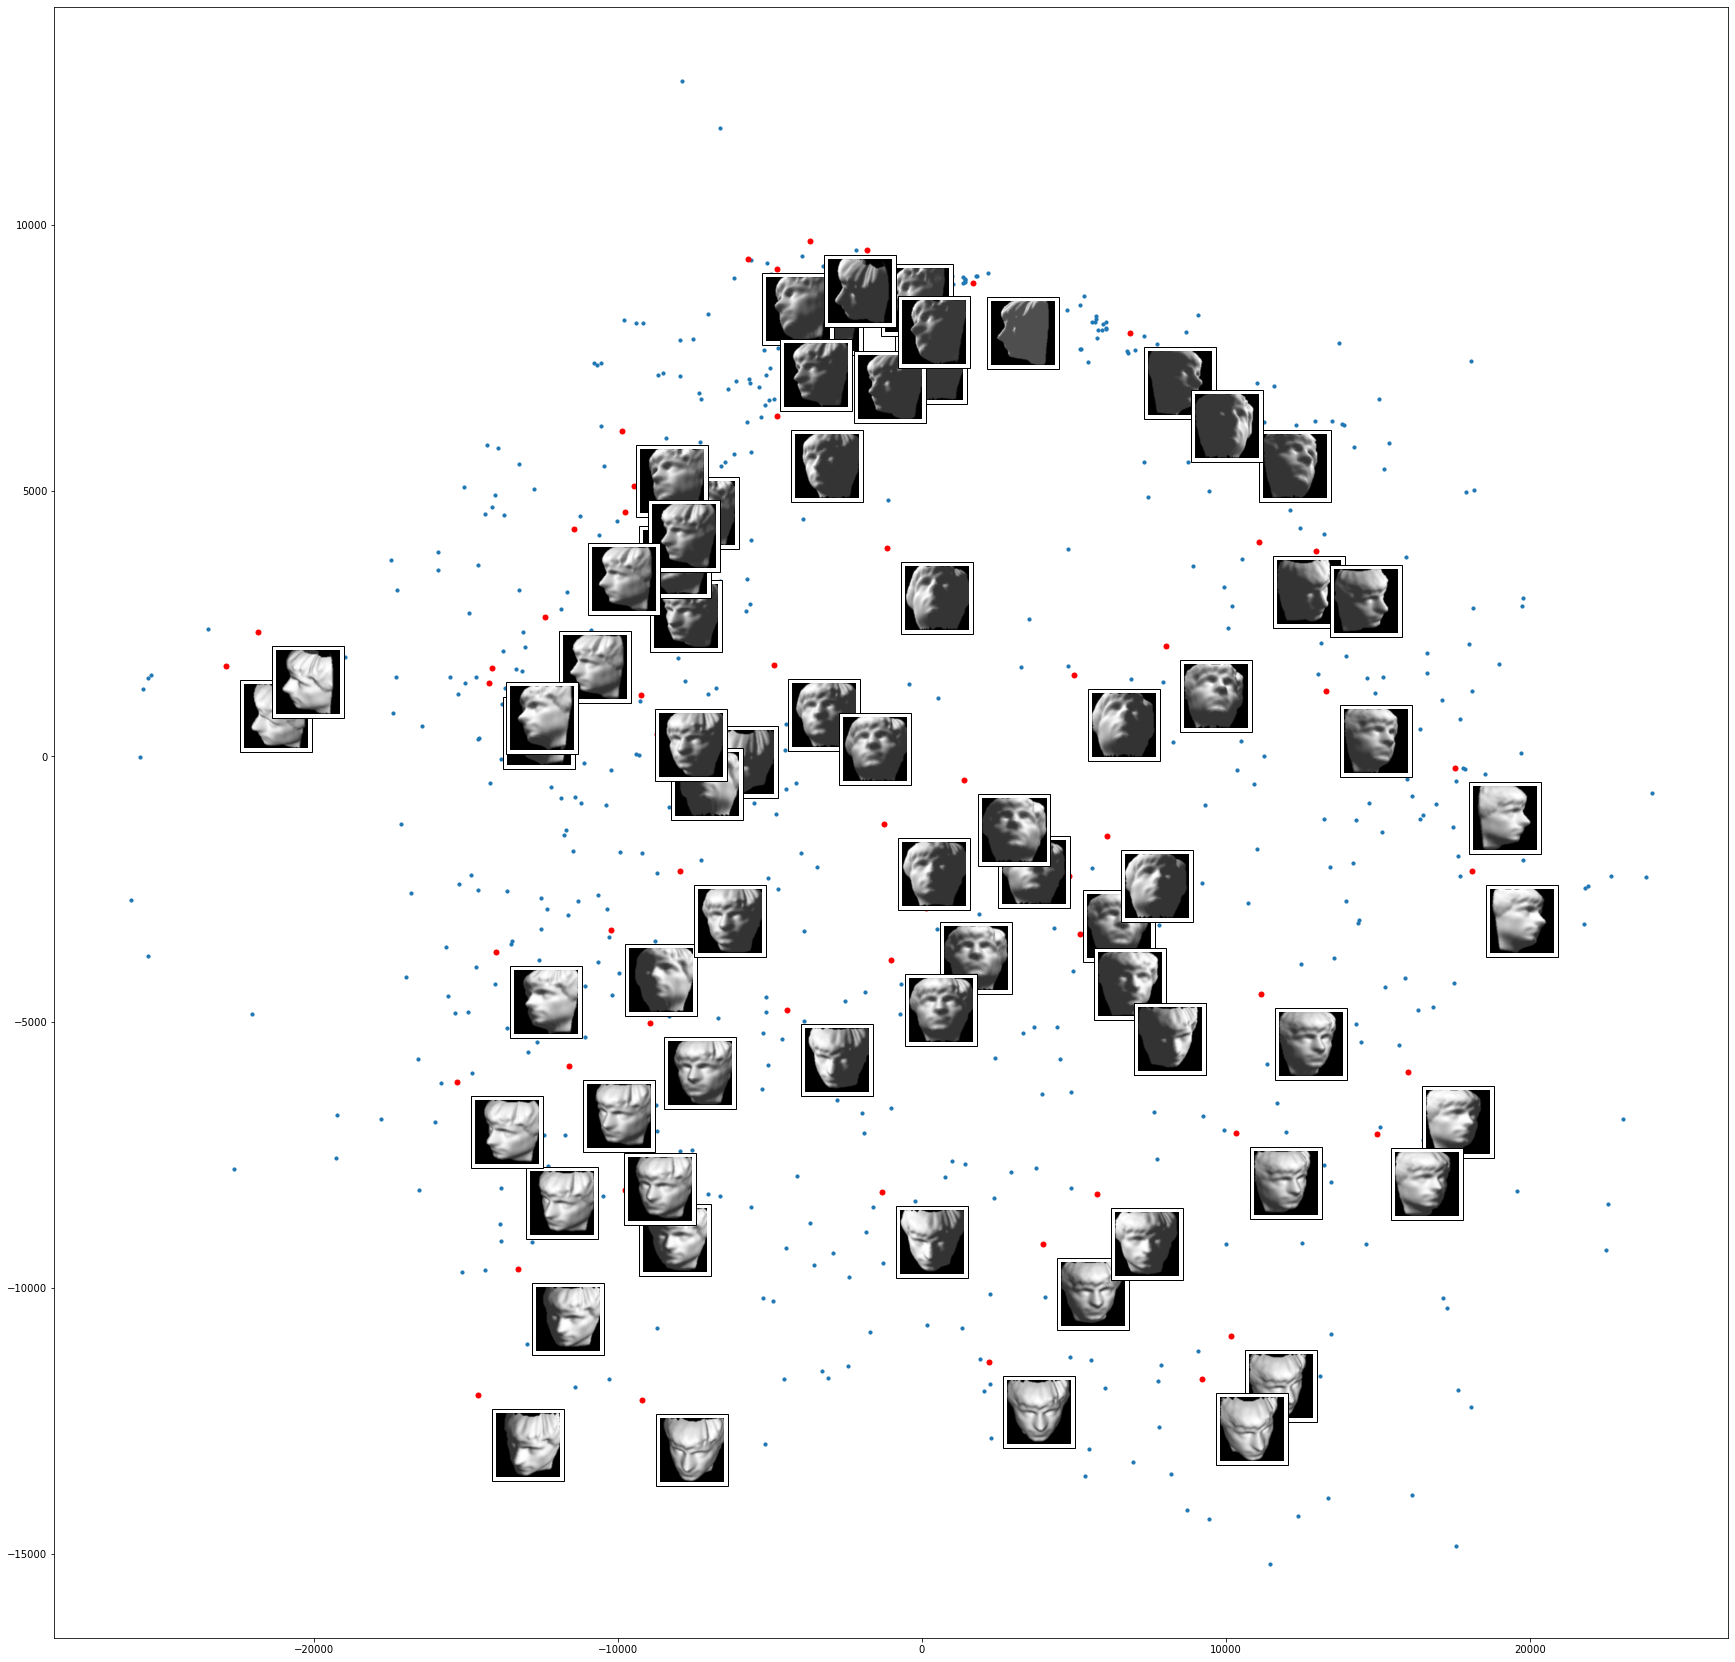

In [14]:
# Visualization
fig, ax = plt.subplots(figsize=(30, 30))
plt.scatter(Z[:, 0], Z[:, 1], s=10)

# Random image annotation
annotate_images_random(ax, Z, data, (64, 64), 1, 70, rng=np.random.default_rng(2))

Faces facing the same direction seem to be located in the same region, indicating that the adjacency matrix and dissimilarity matrix successfully capture relationship between datapoints and hence the embedding in Z successfully captures (dis)similarities between images in 2-dimensional space.

### 2.c. ISOMAP with l1 (Manhattan) distance

Now we repeat section 2 using l1-distance. First, epsilon is picked such that similar average number of neighbors is obtained (approximately epsilon of 460 results in on average 40 neighbors).

average num neighbors: 40.07449856733524


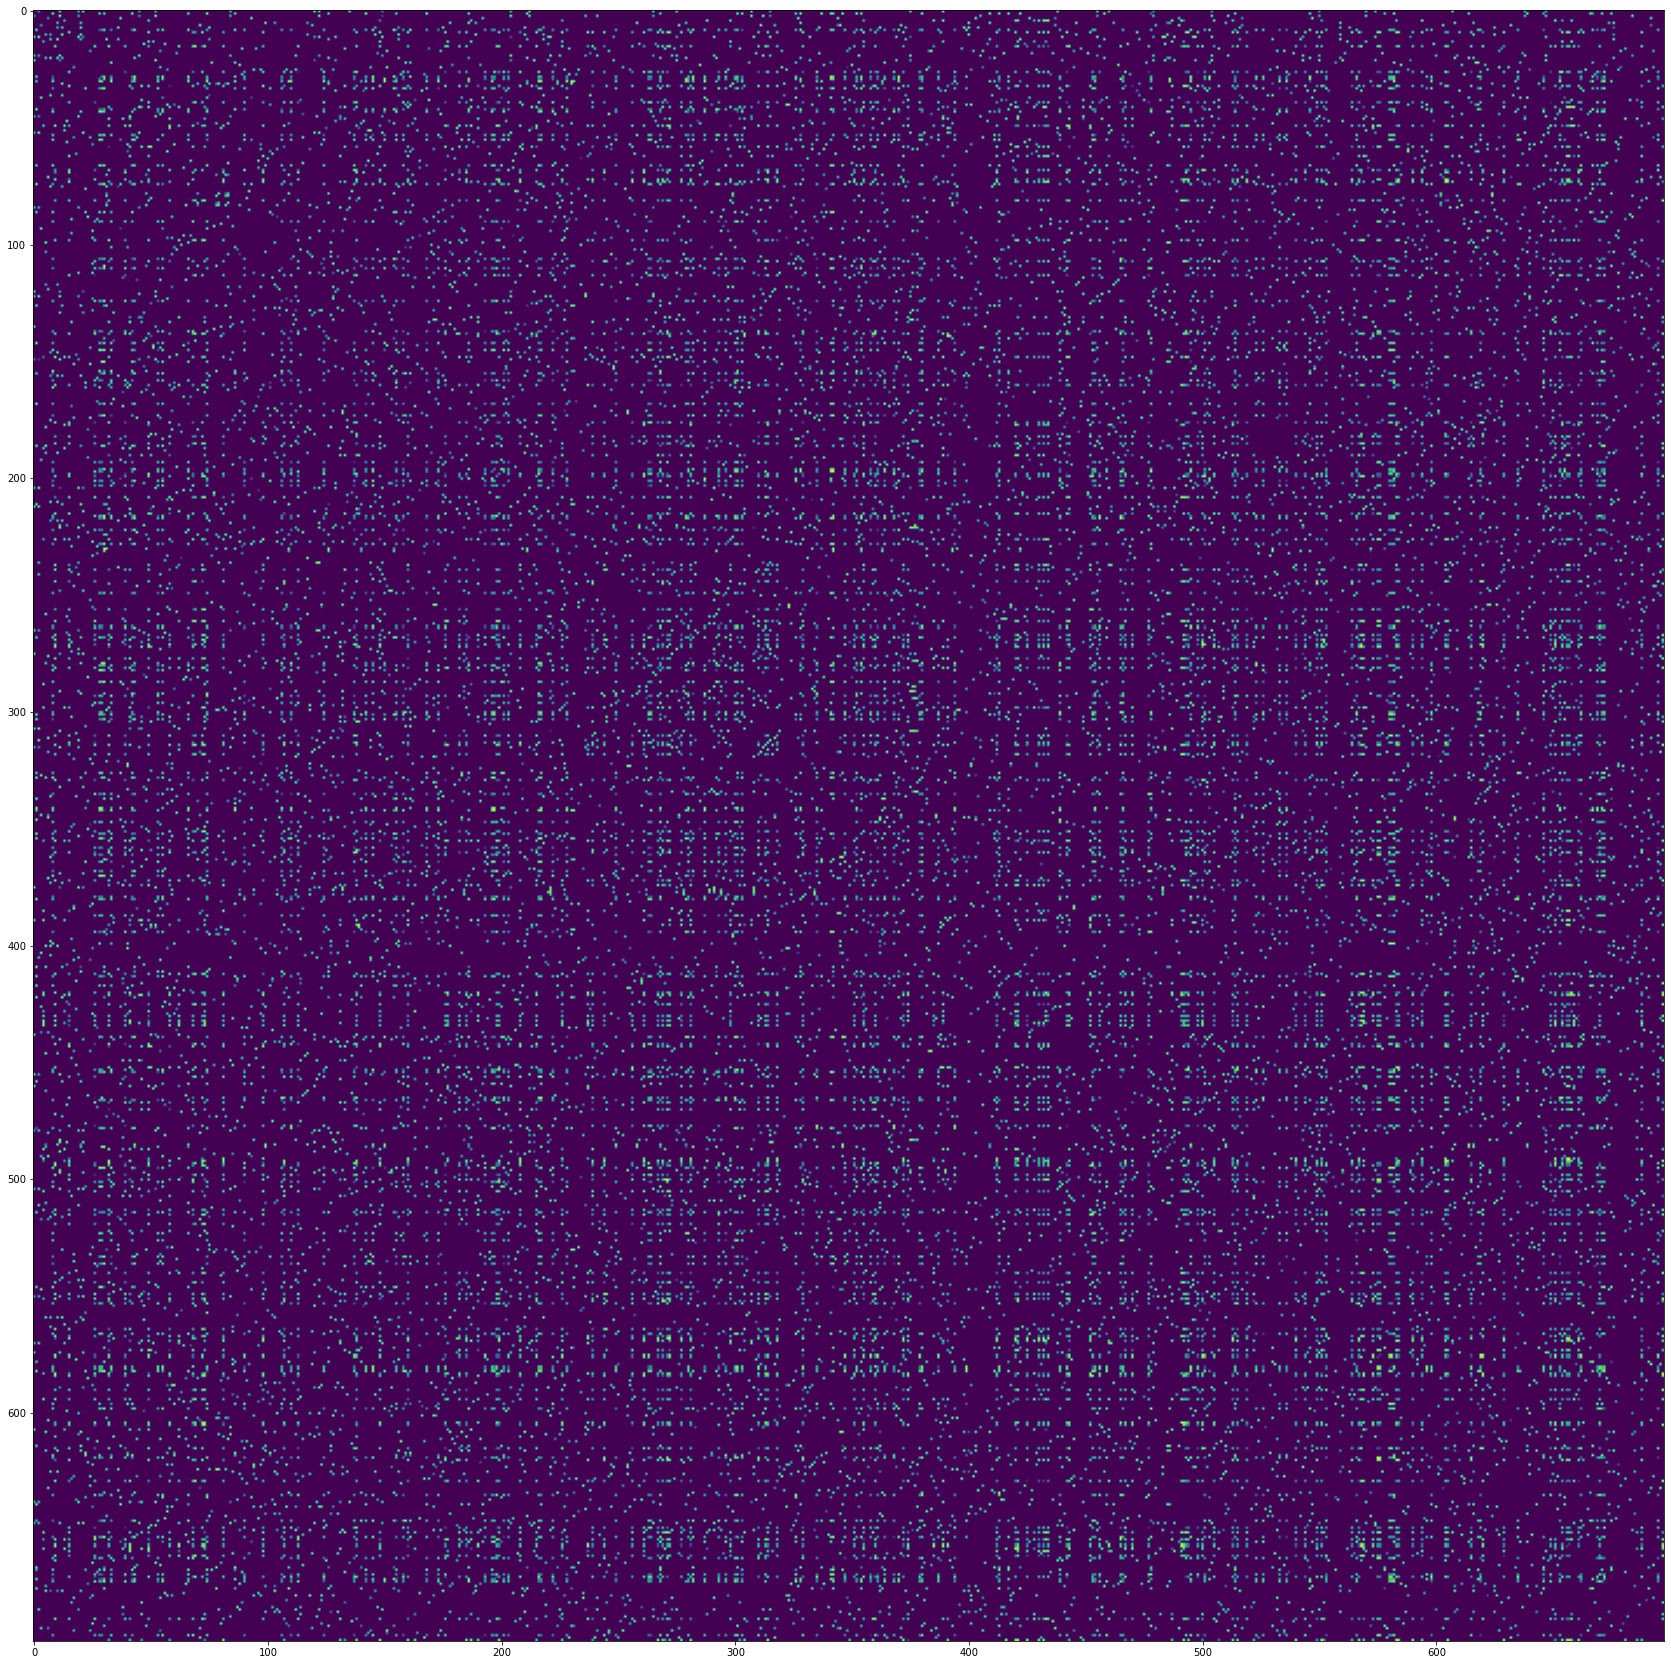

In [15]:
A = construct_distance_matrix(data, data, dist_type='l1')
A[A > 460] = 0
print(f"average num neighbors: {(A > 0).sum(axis=1).mean()}")

plt.figure(figsize=(30, 30))
plt.imshow(A)

Adjacency mtrix looks similar to the one with l2-distance.

In [16]:
Z = isomap.run_isomap(2, 460, dist_type='l1')

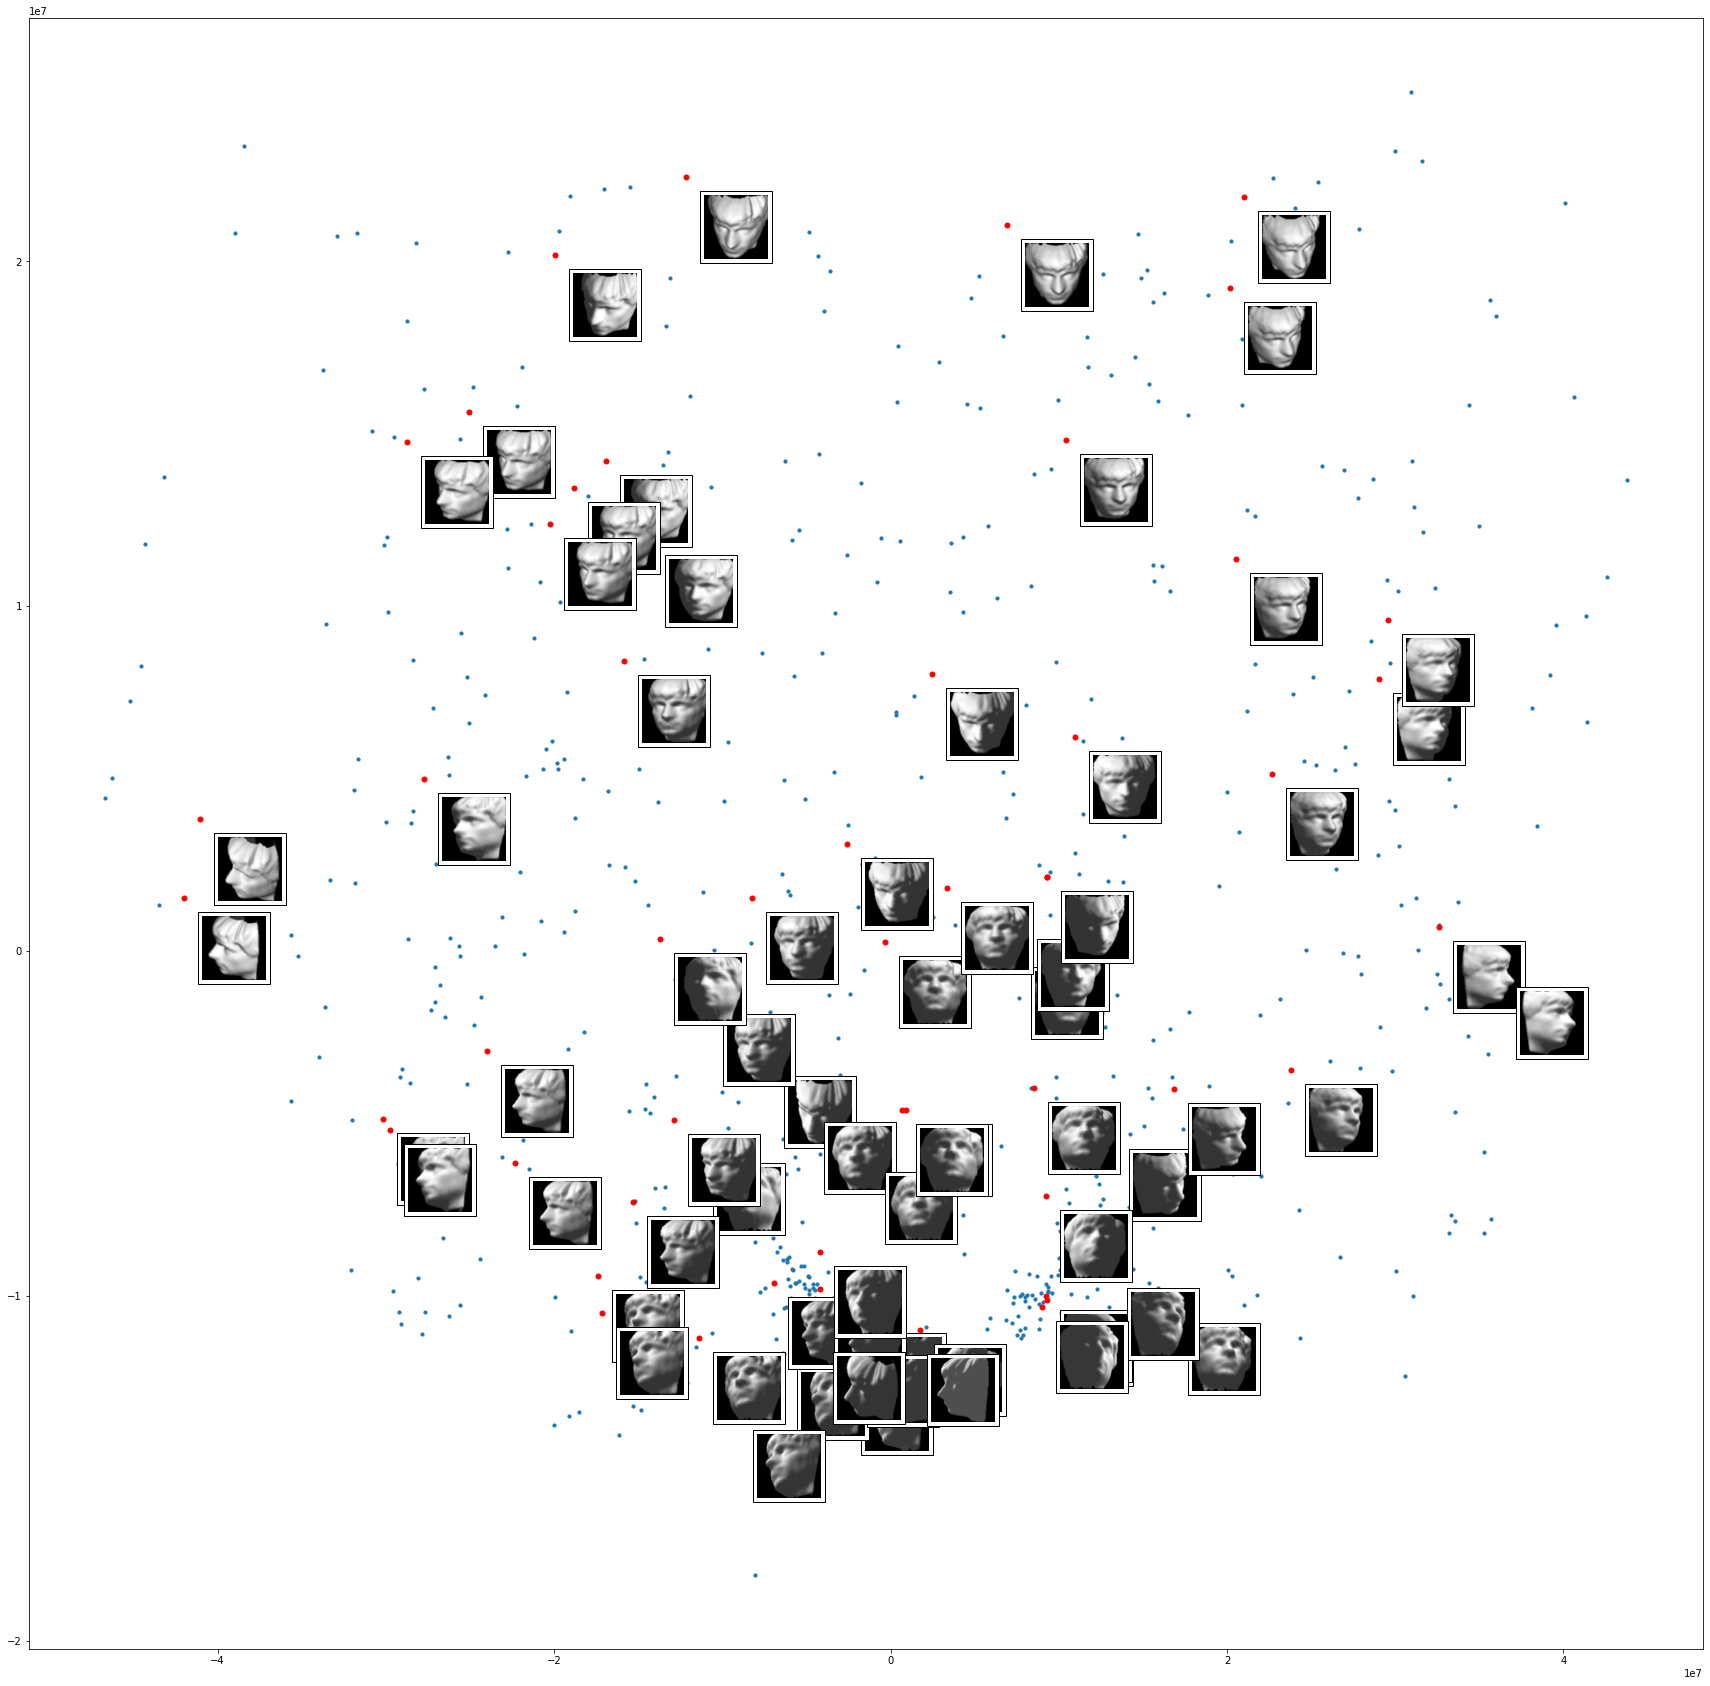

In [17]:
# Visualization
fig, ax = plt.subplots(figsize=(30, 30))
plt.scatter(Z[:, 0], Z[:, 1], s=10)

# Random image annotation
annotate_images_random(ax, Z, data, (64, 64), 1, 70, rng=np.random.default_rng(2))

It can be seen that even though the embedding is different, similarities between images can be captured also with Manhattan distance as long as epsilon is chosen carefully to arrive at a reasonable number of neighbors.

### 2.d. Comparison with PCA

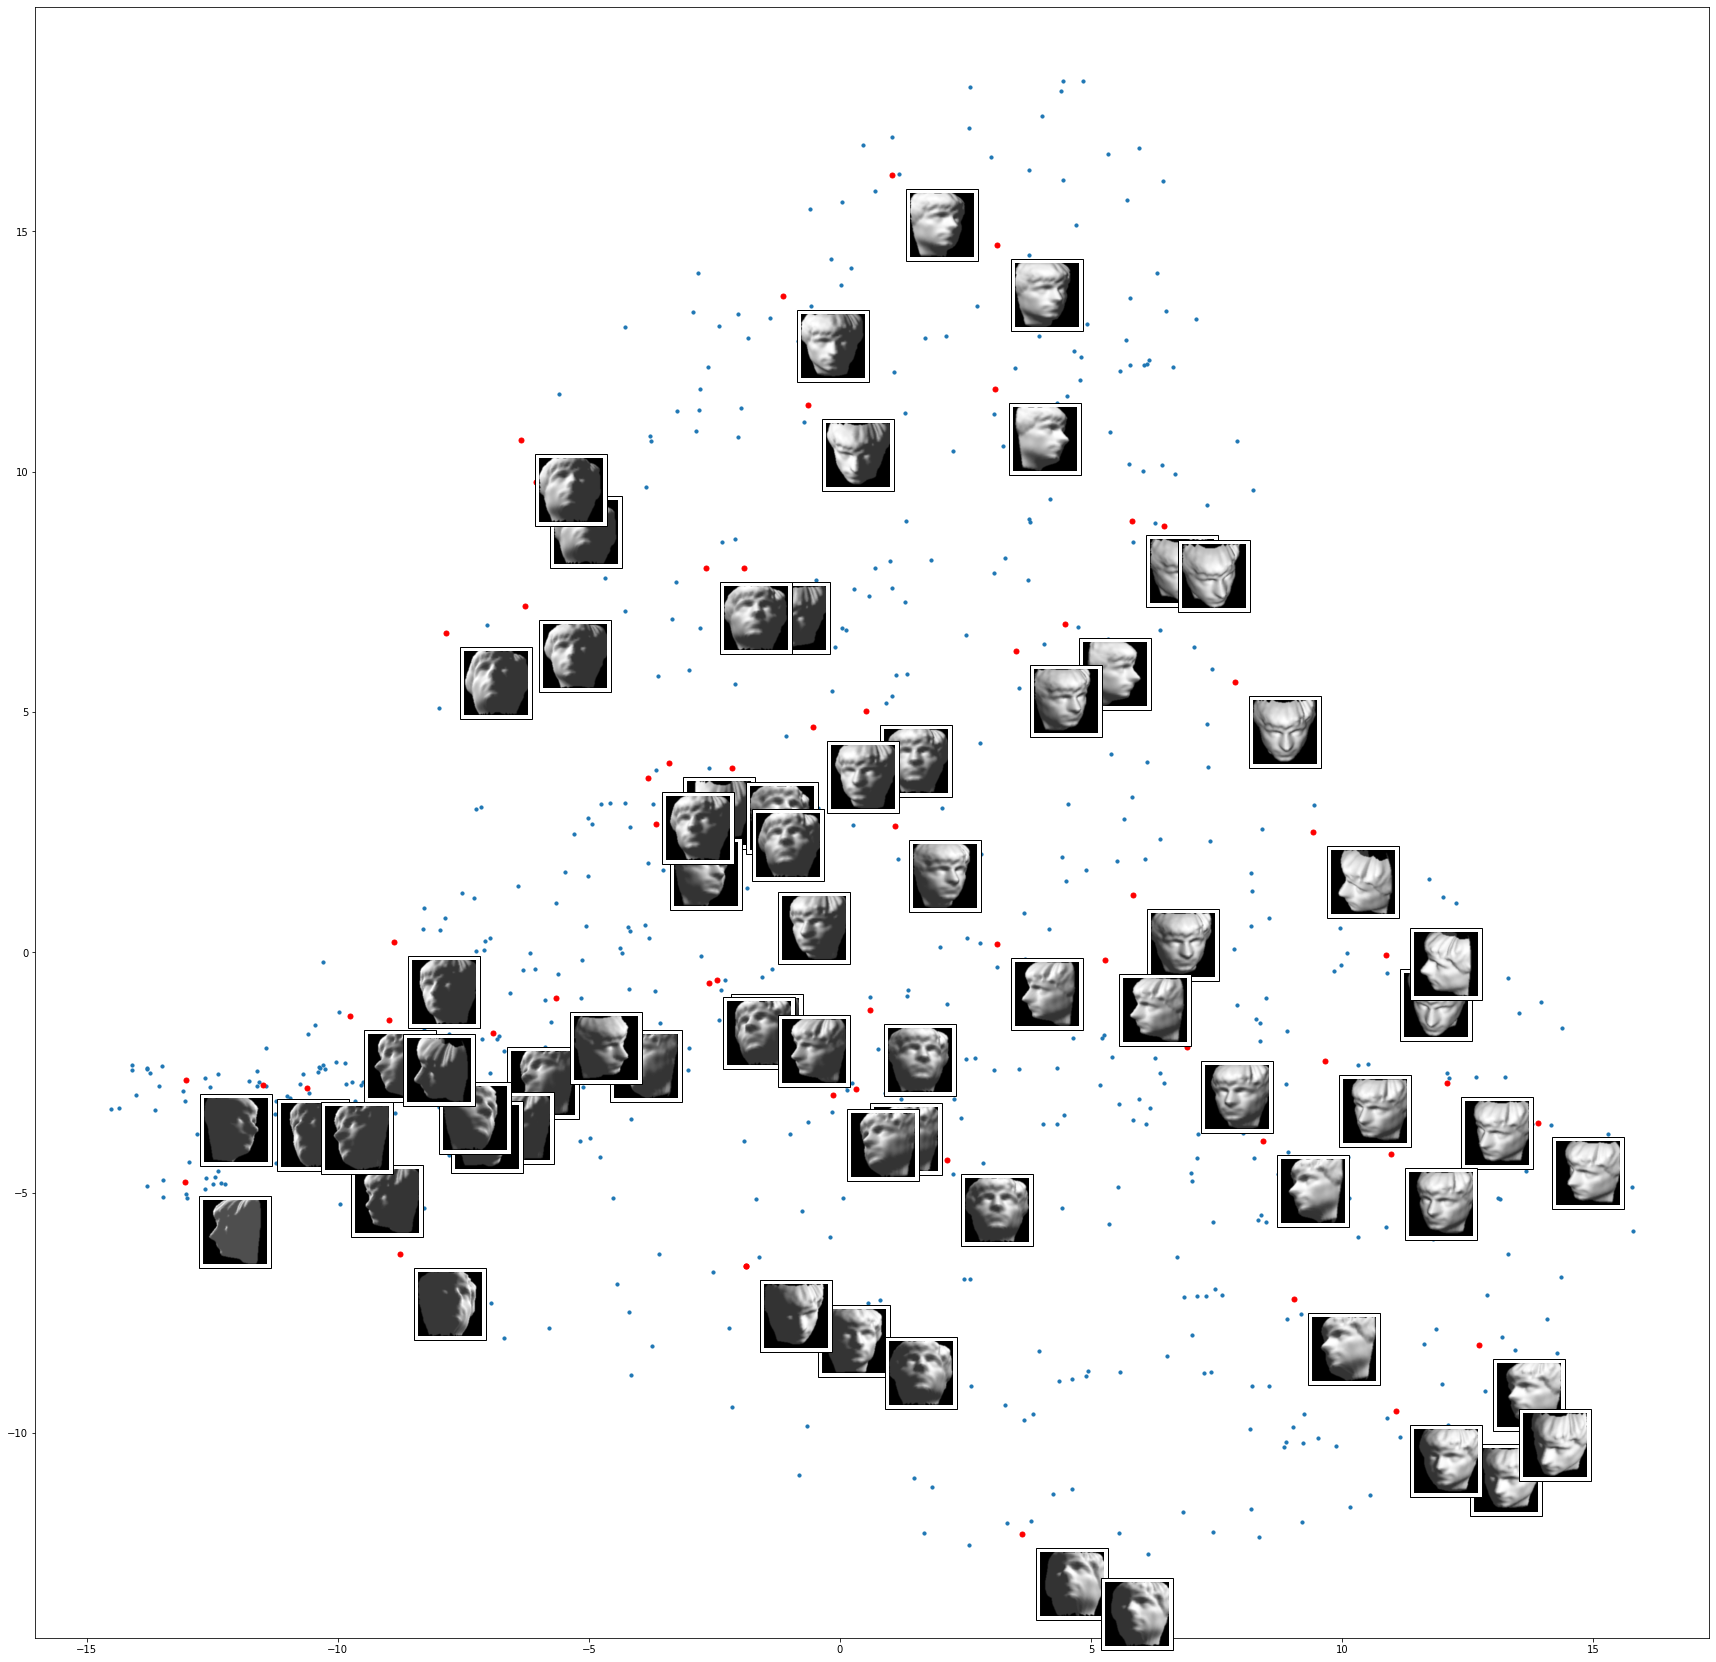

In [18]:
data_red = PCA(n_components=2).fit_transform(data)

# Visualization
fig, ax = plt.subplots(figsize=(30, 30))
plt.scatter(data_red[:, 0], data_red[:, 1], s=10)

# Random image annotation
annotate_images_random(ax, data_red, data, (64, 64), 1, 70, rng=np.random.default_rng(2))

With PCA, grouping of similar faces still occurs. However, the fact that similarity is computed by projecting the data linearly, it is missing a more complicated relationship that makes ISOMAP more successful in grouping the directionality of the faces. For instance, the two leftmost images on the plot clearly indicates opposite facing direction. However, due to their similarity in pixel values (color), their linear projections are close to each other. Furthermore, correct clustering between left-facing images and right-facing images on the bottom left region of the plot seems to be absent.

ISOMAP with its graph-based similarity measure seems to correctly capture the difference between left-facing and right-facing images and correctly cluster them, resulting in a more meaningful grouping.

# 3. PCA: food consumption in European countries

### 3.a. Country similarity based on food consumption

In [19]:
data = pd.read_csv('data/food-consumption.csv')
display(data.head())
country_list = data['Country'].tolist()
X = data[[col for col in data.columns if col != 'Country']].values.astype(float)

Country  Real coffee  Instant coffee  Tea  Sweetener  Biscuits  \
0  Germany           90              49   88         19        57   
1    Italy           82              10   60          2        55   
2   France           88              42   63          4        76   
3  Holland           96              62   98         32        62   
4  Belgium           94              38   48         11        74   

   Powder soup  Tin soup  Potatoes  Frozen fish  ...  Apples  Oranges  \
0           51        19        21           27  ...      81       75   
1           41         3         2            4  ...      67       71   
2           53        11        23           11  ...      87       84   
3           67        43         7           14  ...      83       89   
4           37        23         9           13  ...      76       76   

   Tinned fruit  Jam  Garlic  Butter  Margarine  Olive oil  Yoghurt  \
0            44   71      22      91         85         74       30   
1             9   46      80      66         24         94        5   
2            40   45      88      94         47         36       57   
3            61   81      15      31         97         13       53   
4            42   57      29      84         80         83       20   

   Crisp bread  
0           26  
1           18  
2            3  
3           15  
4            5  

[5 rows x 21 columns]

As we are looking into similarities between countries, each country should be one datapoint. Therefore, the data matrix X is set up with columns corresponding to different foods and rows corresponding to country.

In [20]:
pca = PCAnalyzer(X)
X_red = pca.reduce_dim(2)

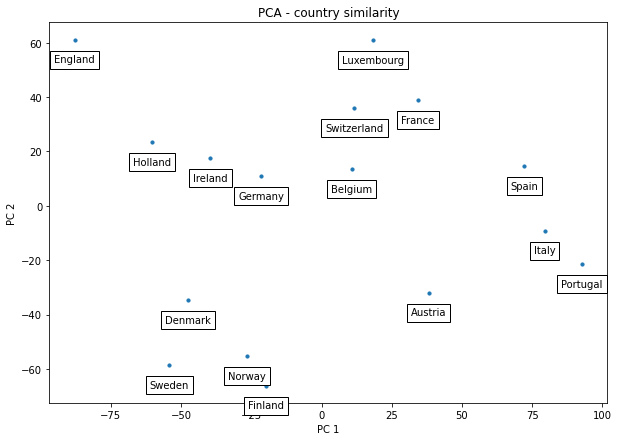

In [21]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('PCA - country similarity')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.scatter(X_red[:, 0], X_red[:, 1], s=10)
annotate(ax, X_red, country_list)

for comparison with skleaarn's PCA package:

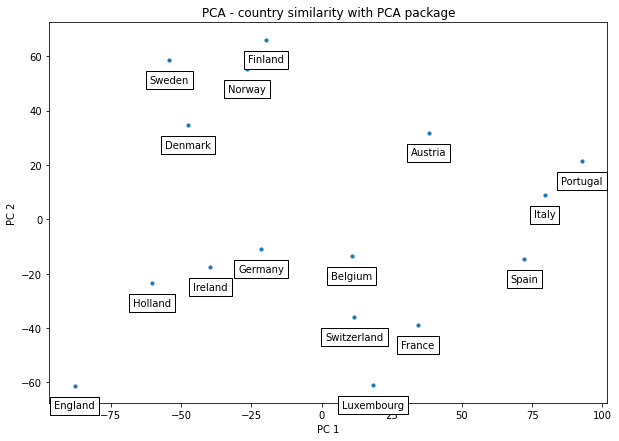

In [22]:
X_red = PCA(n_components=2).fit_transform(X)
# Visualization
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('PCA - country similarity with PCA package')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.scatter(X_red[:, 0], X_red[:, 1], s=10)
annotate(ax, X_red, country_list)

Manual implementation is equivalent to the one with sklearn's PCA package (other than being flipped along y-axis). Is can be seen that the plot of 2 principal components groups countries geographically based on their similarities in food consumption. There seem to be 3 clusters separating the European countries based on their latitudes:

* Sweden, Denmark, Norway and Finland belonging to Northern Europe
* England, Holland, Ireland, Germany, Belgium, Switzeland, France and Luxembourg belonging to Western Europe
* Spain, Italy, Portugal belonging to Southern Europe

This also seems to point out that food consumption is naturally related to climate which perhaps dictates which crops dominate the region. 

### 3.b. Food similarity based on consuming country

Since now we are looking for similarities between food items, the data matrix in the previous section needs to be transposed.

In [23]:
X2 = X.T
food_list = [col for col in data.columns if col != 'Country']
pca = PCAnalyzer(X2)
X2_red = pca.reduce_dim(2)

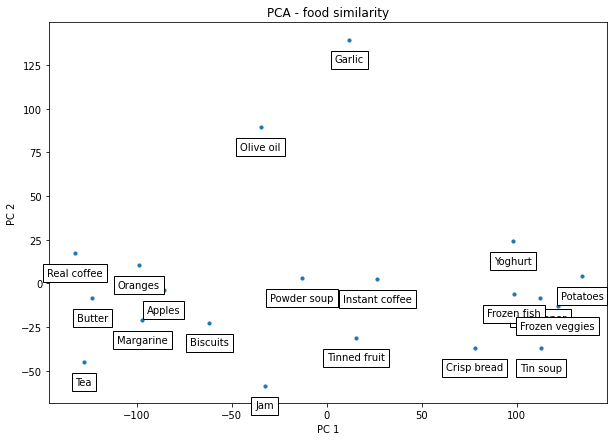

In [24]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('PCA - food similarity')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.scatter(X2_red[:, 0], X2_red[:, 1], s=10)
annotate(ax, X2_red, food_list)

There again seem to be clusters in the food similarity plot. Garlic is often used together with olive oil for cooking. The bottom right seems to be hosting food with long shelf-life including frozen and canned food, yoghurt and potatoes. On the bottom left, we can see food items that are normally consumed together including fruits, butter and margerine with tea and biscuits. The clusters also point out foods that are seemingly used together in particular lifestyle, e.g. fruits + butter + margerine + biscuits + jam indicate baked goods and sweets (commonly consumed with tea in countries like England for example), garlic + olive oil are staples for many cuisines.